**Load Dataset**

In [64]:
# Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")


In [65]:
# Install kaggle library
!pip install kaggle

# Upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"smmmmmmmm","key":"7b133f9532960b035175029dd9cafb37"}'}

In [66]:
# Move kaggle.json to the correct folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d anshtanwar/global-data-on-sustainable-energy
!unzip global-data-on-sustainable-energy.zip

Dataset URL: https://www.kaggle.com/datasets/anshtanwar/global-data-on-sustainable-energy
License(s): Attribution 4.0 International (CC BY 4.0)
global-data-on-sustainable-energy.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  global-data-on-sustainable-energy.zip
replace global-data-on-sustainable-energy (1).csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [67]:
data = pd.read_csv("global-data-on-sustainable-energy (1).csv")

# Basic information about the dataset
data.head(500)
data.info()

# Check for missing values
#print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3649 entries, 0 to 3648
Data columns (total 21 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   Entity                                                            3649 non-null   object 
 1   Year                                                              3649 non-null   int64  
 2   Access to electricity (% of population)                           3639 non-null   float64
 3   Access to clean fuels for cooking                                 3480 non-null   float64
 4   Renewable-electricity-generating-capacity-per-capita              2718 non-null   float64
 5   Financial flows to developing countries (US $)                    1560 non-null   float64
 6   Renewable energy share in the total final energy consumption (%)  3455 non-null   float64
 7   Electricity from fossil fuels (TW

**Exploratory Data Analysis**


---


Electricity From Renewables and fossil fuels Over Time

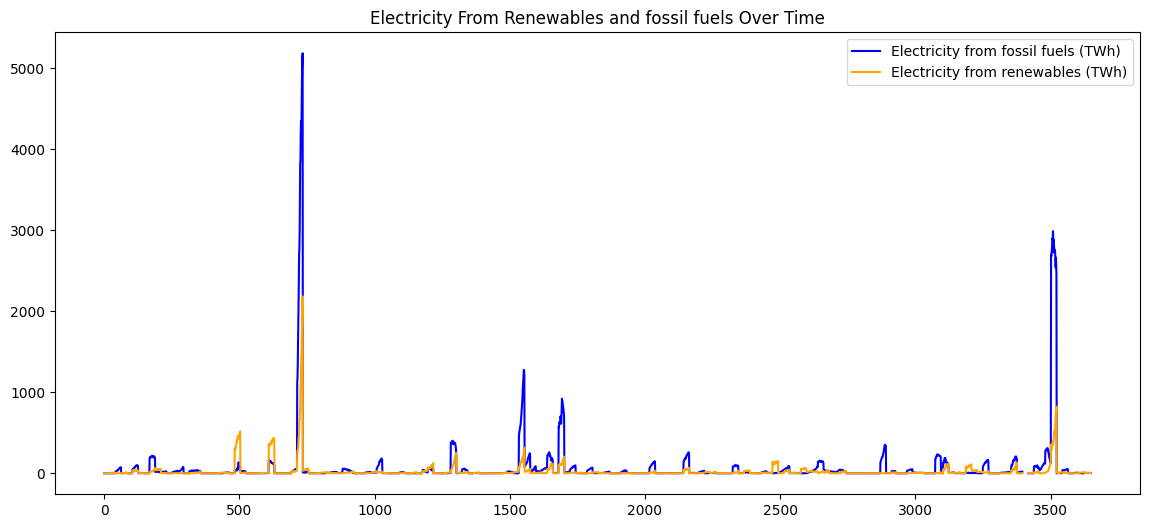

In [68]:
# Convert DateTime to a proper datetime object
#data['Year'] = pd.to_datetime(data['Year'])
#data.set_index('Year', inplace=True)

# Time-series plots
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Electricity from fossil fuels (TWh)'], label="Electricity from fossil fuels (TWh)", color="blue")
plt.plot(data.index, data['Electricity from renewables (TWh)'], label="Electricity from renewables (TWh)", color="orange")
plt.title("Electricity From Renewables and fossil fuels Over Time")
plt.legend()
plt.show()

Correlation Heatmap of Lags

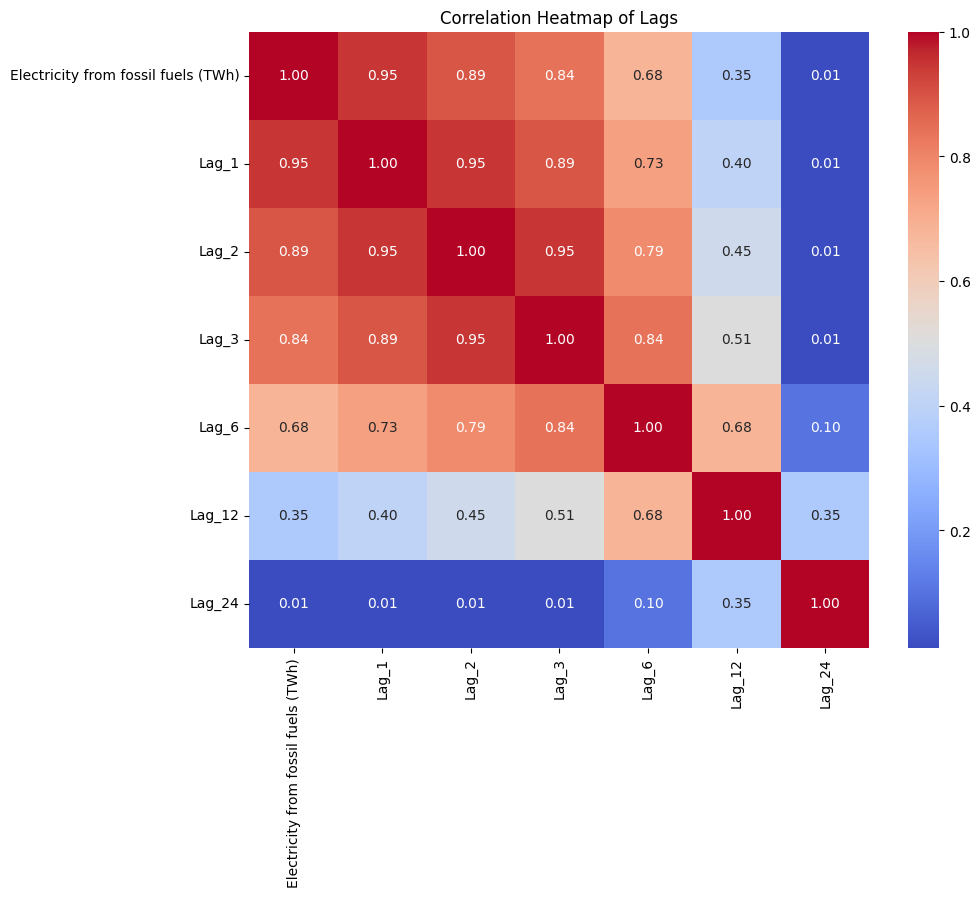

In [69]:
# Lag correlation heatmap
lags = [1, 2, 3, 6, 12, 24]
lagged_data = pd.concat([data['Electricity from fossil fuels (TWh)'].shift(lag) for lag in lags], axis=1)
lagged_data.columns = [f"Lag_{lag}" for lag in lags]

correlation_matrix = pd.concat([data[['Electricity from fossil fuels (TWh)']], lagged_data], axis=1).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Lags")
plt.show()

Distribution of Electricity Production and Consumption

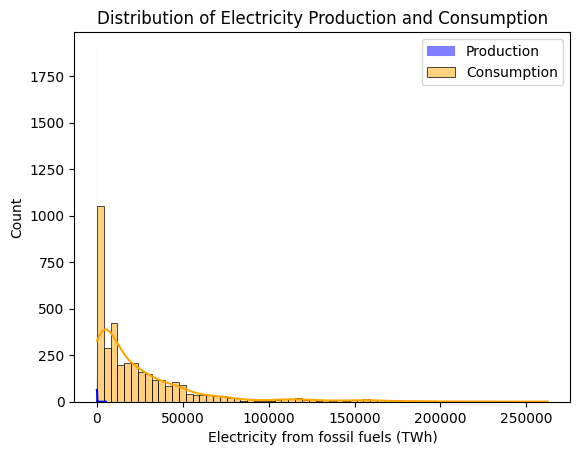

In [71]:
# Distribution plots
sns.histplot(data['Electricity from fossil fuels (TWh)'], kde=True, color="blue", label="Production")
sns.histplot(data['Primary energy consumption per capita (kWh/person)'], kde=True, color="orange", label="Consumption")
plt.title("Distribution of Electricity Production and Consumption")
plt.legend()
plt.show()

**Machine Learning Models**


---

Data Preprocessing

In [72]:
# Lag features
data['Lag_1'] = data['Electricity from fossil fuels (TWh)'].shift(1)
data['Lag_2'] = data['Electricity from fossil fuels (TWh)'].shift(2)
data['Lag_3'] = data['Electricity from fossil fuels (TWh)'].shift(3)

# Drop NaN rows due to lagging
data.dropna(inplace=True)

# Features and target
X = data[['Electricity from fossil fuels (TWh)', 'Year', 'Lag_1', 'Lag_2', 'Lag_3']]
y = data['Electricity from fossil fuels (TWh)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Model Training


In [89]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

# Train and evaluate models
results = {}
detailed_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    evs = explained_variance_score(y_test, predictions)

    results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2 Score': r2, 'Explained Variance': evs}
    detailed_results[name] = predictions

# Results
results_df = pd.DataFrame(results).T
print(results_df)


                            MAE           MSE          RMSE  R2 Score  \
Linear Regression  4.775568e-14  7.124129e-27  8.440455e-14  1.000000   
Decision Tree      1.399797e+01  3.386813e+03  5.819633e+01  0.978349   
Random Forest      8.568962e+00  8.937548e+02  2.989573e+01  0.994287   

                   Explained Variance  
Linear Regression            1.000000  
Decision Tree                0.979147  
Random Forest                0.994526  


Visualizing metrics

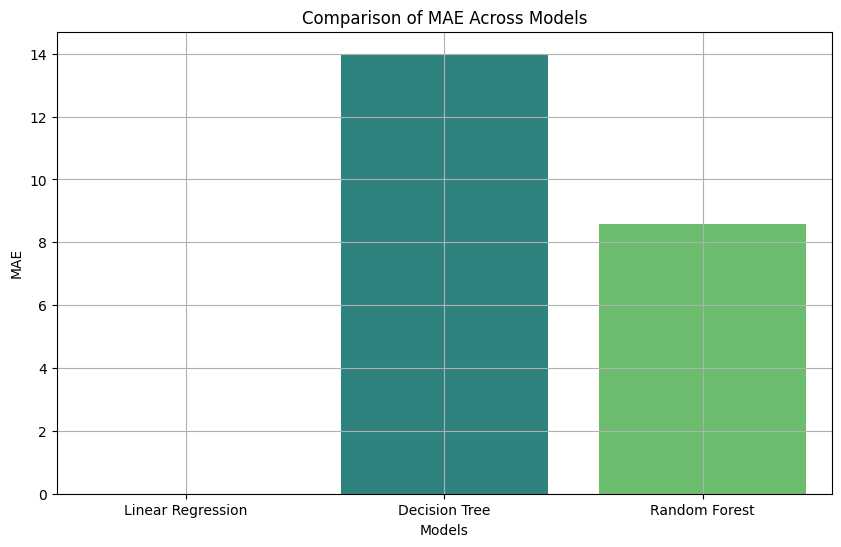

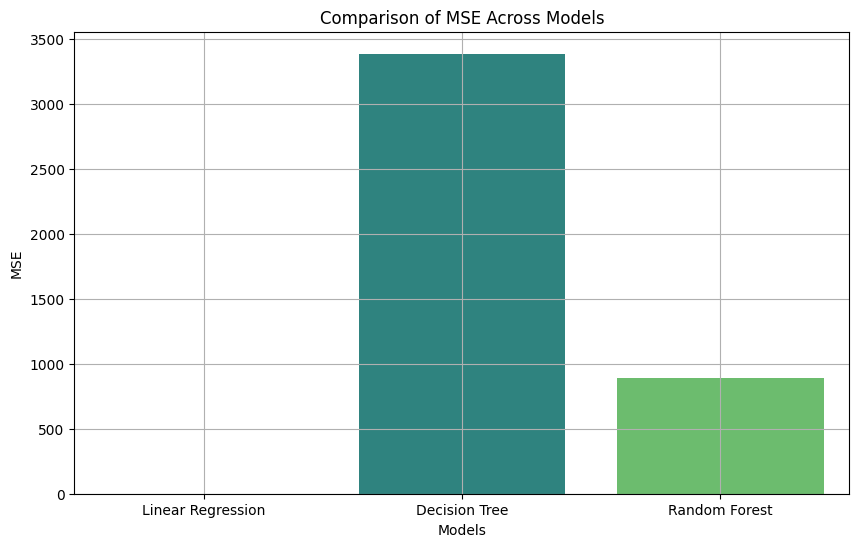

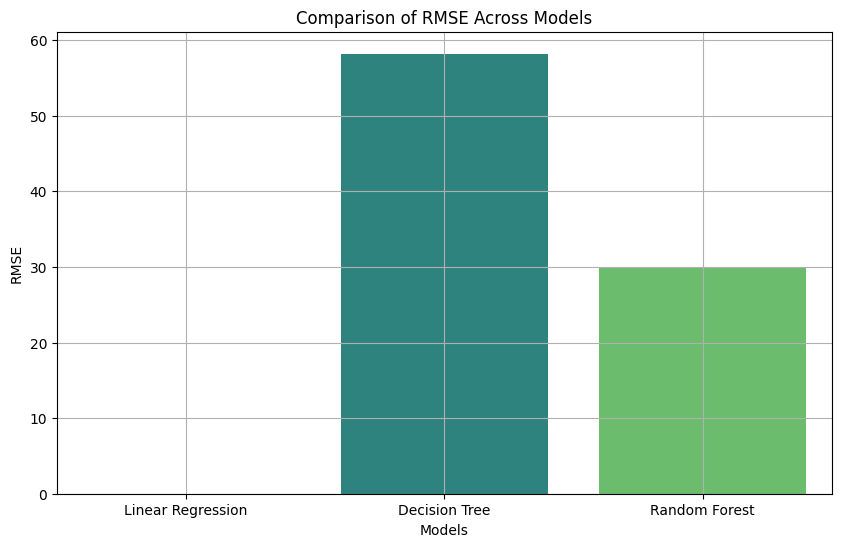

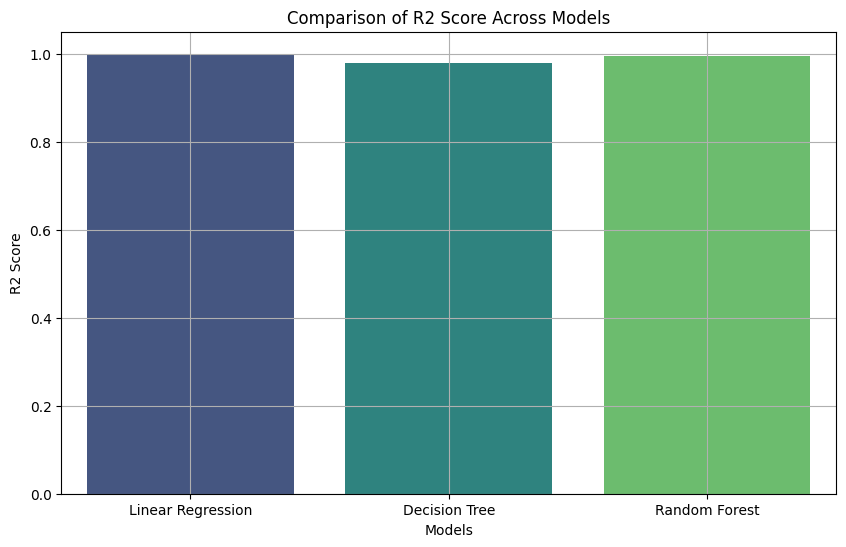

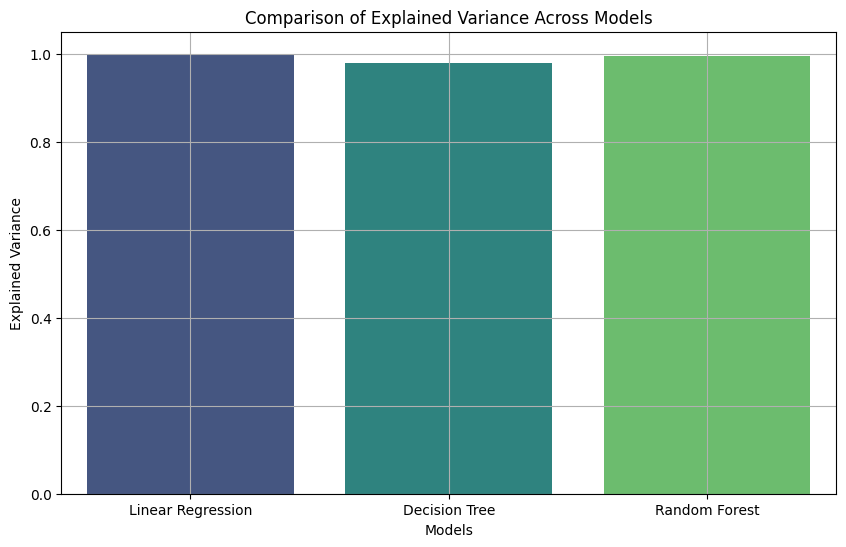

In [74]:
# Visualizing metrics
metrics = ['MAE', 'MSE', 'RMSE', 'R2 Score', 'Explained Variance']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=results_df.index, y=results_df[metric], palette="viridis")
    plt.title(f"Comparison of {metric} Across Models")
    plt.ylabel(metric)
    plt.xlabel("Models")
    plt.grid(True)
    plt.show()


Residual Distribution

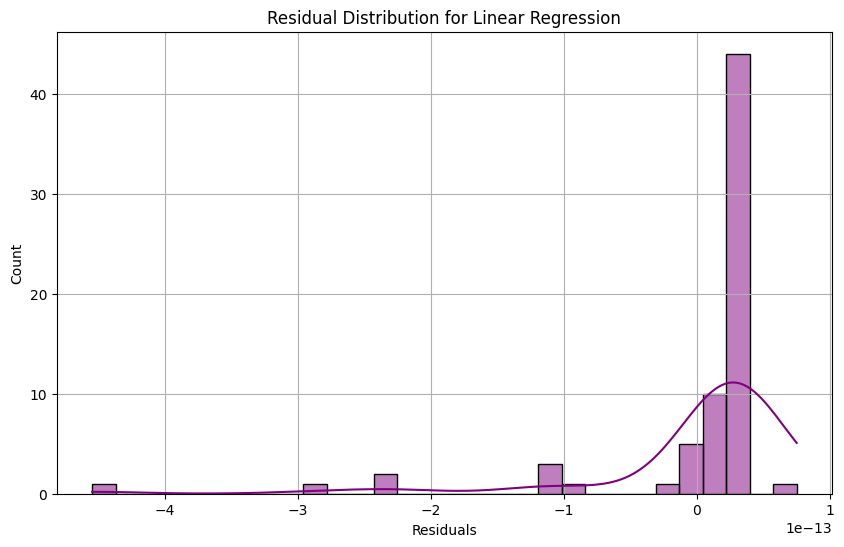

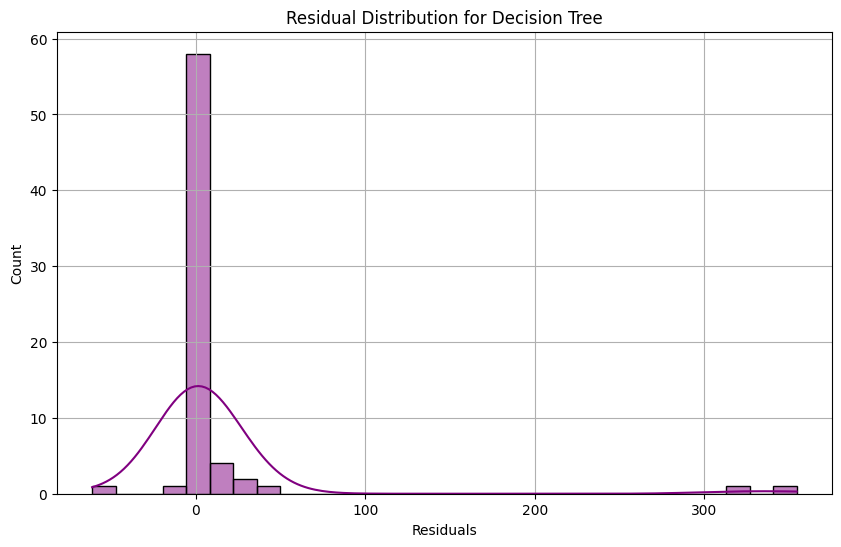

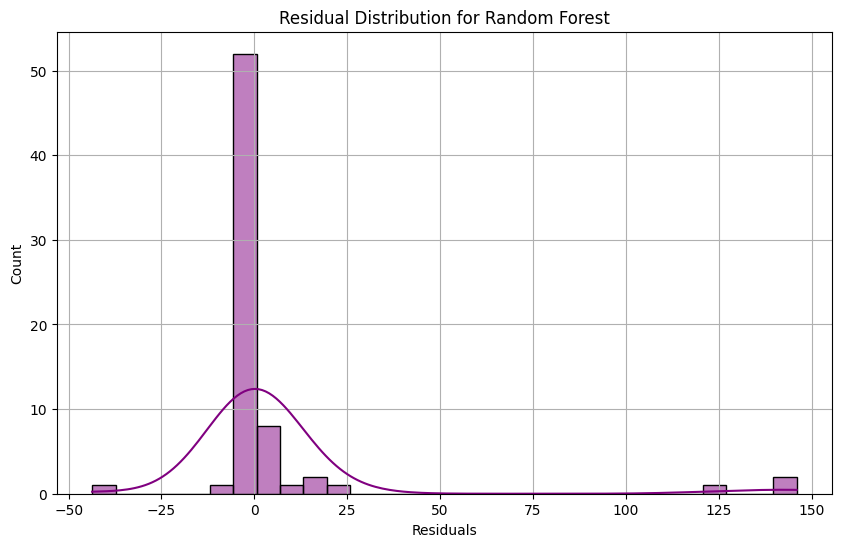

In [75]:
for name, predictions in detailed_results.items():
    residuals = y_test - predictions

    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=30, color="purple")
    plt.title(f"Residual Distribution for {name}")
    plt.xlabel("Residuals")
    plt.grid(True)
    plt.show()



Actual vs Predicted

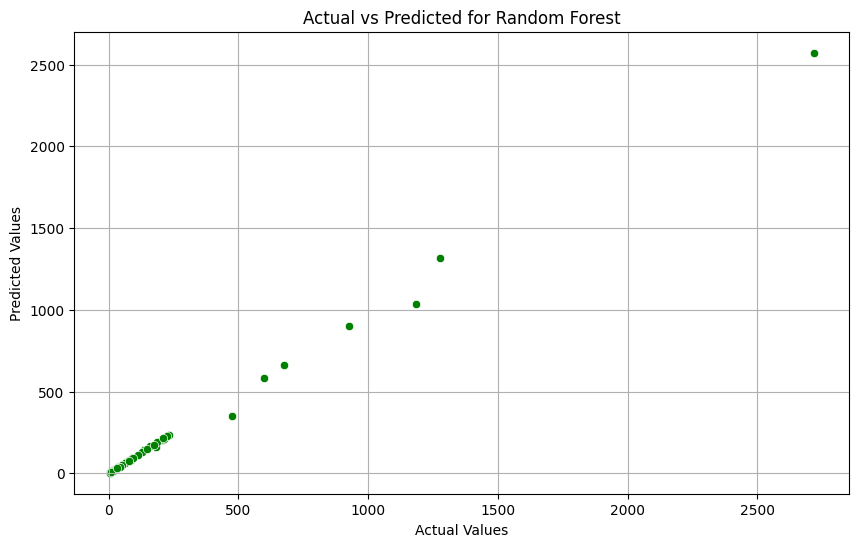

In [76]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions, color="green")
plt.title(f"Actual vs Predicted for {name}")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()

**Forecasting**

In [77]:
# Fit ARIMA model
arima_model = ARIMA(data['Electricity from fossil fuels (TWh)'], order=(5, 1, 0))
fitted_arima = arima_model.fit()

# Forecast
forecast_steps = 30
forecast = fitted_arima.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='H')[1:]


Visualize Forecasts

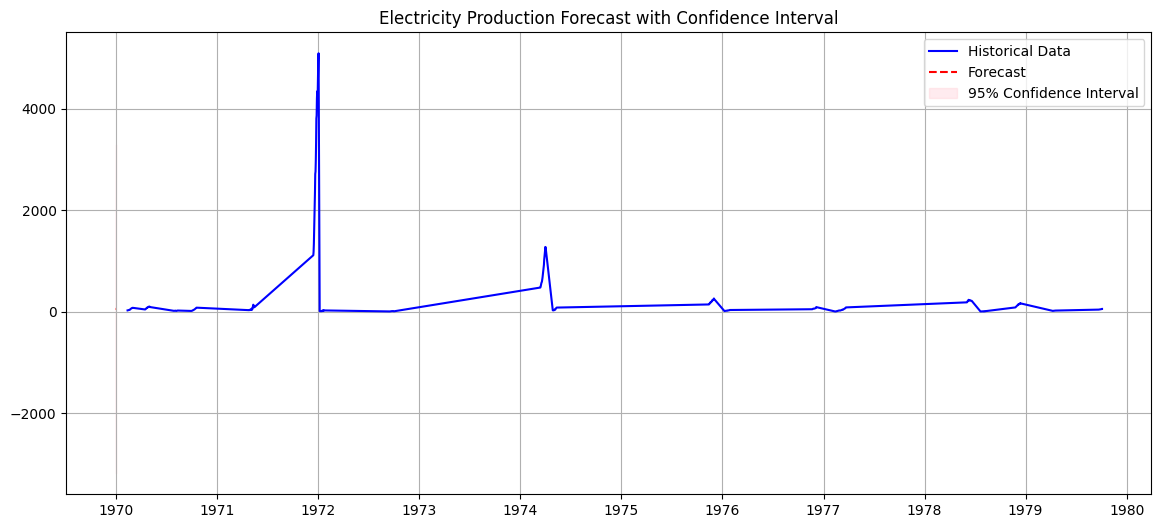

In [88]:
# Confidence intervals
forecast_ci = fitted_arima.get_forecast(steps=forecast_steps).conf_int(alpha=0.05)

# Plot forecast with confidence intervals
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Electricity from fossil fuels (TWh)'], label="Historical Data", color="blue")
plt.plot(forecast_index, forecast, label="Forecast", linestyle="--", color="red")
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label="95% Confidence Interval")
plt.title("Electricity Production Forecast with Confidence Interval")
plt.legend()
plt.grid(True)
plt.show()

Forecast Residuals Distribution

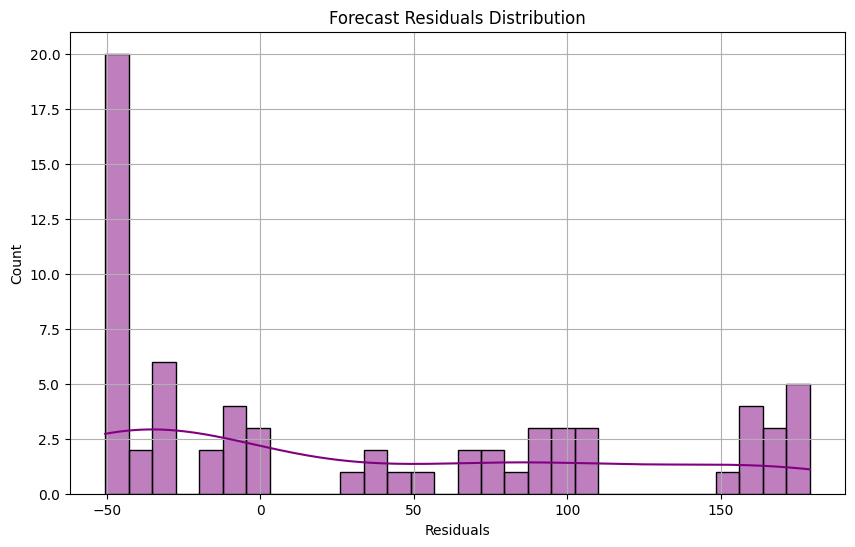

In [87]:
# Histogram of residuals
forecast_residuals = test - arima_forecast
plt.figure(figsize=(10, 6))
sns.histplot(forecast_residuals, kde=True, bins=30, color="purple")
plt.title("Forecast Residuals Distribution")
plt.xlabel("Residuals")
plt.grid(True)
plt.show()